In [1]:
# all imports
import pandas as pd
import numpy as np
import seaborn as sns
import time
import itertools
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from math import sqrt
import os.path

In [2]:
if os.path.isfile("bar_data.csv"):
    bar_data = pd.read_csv("bar_data.csv", index_col=0)
else:
    # Read data
    data = pd.read_csv("Training Data_PERPOC.csv")

    # Let's do the analysis for 'Bar'
    bar_data = data.loc[data['SEGMENT_POC'] == 'Bar'].copy()

    # Choose the right features
    features = ['YEAR', 'MONTH', 'DAY', 'COD_POC', 'SEGMENT_POC', 'DISCOUNT',
               'COUNTPOC', 'COD_PROD', 'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
               'COD_ACAO', 'WEEKOFMONTH', 'DAYOFWEEK', 'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
               'POL_PTR', 'VOLPRODDAY', 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
               'HUMAVG', 'PRECIP', 'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
               'TEMPMAX_D-2', 'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
               'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
               'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
               'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
               'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
               'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
               'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
               'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
               'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
               'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
               'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
               'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
               'UNEMPLOYMENTRATE_m-1', 'REPASSE', 'REPASSE+1', 'REPASSE-1']

    # Create a `DATE` column
    bar_data.insert(0, 'DATE', pd.to_datetime(bar_data[['YEAR', 'MONTH', 'DAY']]))

    # Create a `PTR` column, which takes into account the discount
    bar_data["PTR"] = bar_data["POL_PTR"] * (1 + bar_data["DISCOUNT"])

    # Sort the data set on the basis of time
    bar_data.sort_values(['YEAR', 'MONTH', 'DAY'], ascending=[True, True, True], inplace=True)

    # Create `MONTH` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["MONTH"], prefix="MONTH")], axis=1)

    # Create `WEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["WEEKOFMONTH"], prefix="WEEK")], axis=1)

    # Create `DAYOFWEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["DAYOFWEEK"], prefix="DAYOFWEEK")], axis=1)

    # Create `NEARWEEKEND` dummy
    bar_data["NEARWEEKEND"] = bar_data["DAYOFWEEK_0"] | bar_data["DAYOFWEEK_6"] | bar_data["DAYOFWEEK_5"] | bar_data["DAYOFWEEK_4"]

    # Create `VOLPRODDAYWEEKSKU` across all PoCs
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_PROD"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_PROD"], suffixes=["", "WEEKSKU"])

    # Create `VOLPRODDAYWEEK` for each PoC
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_POC"], suffixes=["", "WEEK"])

    # Perform log transforms for the volumes
    bar_data["LOG_VOLPRODDAY"] = np.log(bar_data["VOLPRODDAY"])
    bar_data["LOG_VOLPRODDAYWEEK"] = np.log(bar_data["VOLPRODDAYWEEK"])
    bar_data["LOG_VOLPRODDAYWEEKSKU"] = np.log(bar_data["VOLPRODDAYWEEKSKU"])

    # Perform log tranform for PTR
    bar_data["LOG_PTR"] = np.log(bar_data["PTR"])
    bar_data["LOG_POL_PTR"] = np.log(bar_data["POL_PTR"])

    # Create `DAYSINMONTH`
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"].isin([1, 3, 5, 7, 8, 10, 12]), 31, 30)
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"] == 2, 28, bar_data["DAYSINMONTH"])

    # Create a `POC_STOCK` column for each PoC
    # Get the assumed mean daily sales, when I assume every month, `total sales` = `total purchase`
    monthly_sales = bar_data.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=monthly_sales, how="left", on=["YEAR", "MONTH", "COD_POC"], suffixes=["", "_MEAN"])
    bar_data["VOLPRODDAY_MEAN"] /= bar_data["DAYSINMONTH"]

    # Get the `SALESTODATE`, which is according to our "monthly" assumption
    bar_data["SALESTODATE"] = bar_data["VOLPRODDAY_MEAN"] * bar_data["DAY"]

    # Get the `PURCHASETODATE`
    daily_purchase = bar_data.groupby(["YEAR", "MONTH", "DAY", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].apply(lambda x: x.cumsum()).values
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["COD_POC"])["PURCHASETODATE"].apply(lambda x: x.shift(1))
    daily_purchase = daily_purchase.sort_values(["COD_POC", "YEAR", "MONTH", "DAY"]).reset_index()

    # Set the first entry in `PURCHASETODATE` for every month to 0
    for i in range(1, daily_purchase.shape[0]):
        if i == 1:
            daily_purchase.loc[i - 1, "PURCHASETODATE"] = 0

        if ((daily_purchase["MONTH"][i - 1] != daily_purchase["MONTH"][i]) or 
            (daily_purchase["COD_POC"][i - 1] != daily_purchase["COD_POC"][i])):
            daily_purchase.loc[i, "PURCHASETODATE"] = 0

    # Merge to POC data
    bar_data = bar_data.merge(right=daily_purchase, how="left", on=["YEAR", "MONTH", "DAY", "COD_POC"], suffixes=["", "_DAILY"])

    # Create the `POC_STOCK` column
    bar_data["POC_STOCK"] = bar_data["PURCHASETODATE"] - bar_data["SALESTODATE"]
    
    # Save the bar_data for future use
    bar_data.to_csv("bar_data.csv")

In [3]:
features = [
             # Engineered features
             "POC_STOCK",
             "LOG_PTR",
             # "LOG_POL_PTR",
             'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_11', 'MONTH_12',
             "WEEK_1", "WEEK_2", "WEEK_3", "WEEK_4", "WEEK_5",
             "DAYOFWEEK_0", "DAYOFWEEK_1", "DAYOFWEEK_2", "DAYOFWEEK_3", "DAYOFWEEK_4", "DAYOFWEEK_5",
             "NEARWEEKEND",
             "LOG_VOLPRODDAYWEEK",
             "LOG_VOLPRODDAYWEEKSKU",

             # All features which were already present   
             'COD_POC', 
             # 'DISCOUNT',
             'COUNTPOC', 
             # 'COD_PROD', 
             'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
             'COD_ACAO', 
             # 'WEEKOFMONTH', 
             # 'DAYOFWEEK', 
             'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
             # 'POL_PTR', 
             'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
             'HUMAVG', 'PRECIP', 
             #'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
             #'TEMPMAX_D-2', 
             #'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
             #'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
             #'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
             #'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
             #'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
             #'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
             'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
             'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
             'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
             'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
             'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
             'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
             'UNEMPLOYMENTRATE_m-1', 
             
             'REPASSE', 'REPASSE+1', 'REPASSE-1'
            ]

model_data = bar_data[bar_data["COD_PROD"] == 9886]

X = model_data[features]
# Remove features which have low variance - using Variance Thresholding
selector = VarianceThreshold(threshold=1e-03)
selector.fit(X)
X = X.loc[:, selector.get_support()]
X = sm.add_constant(X)

y = model_data["LOG_VOLPRODDAY"]

# Run an OLS model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1378.
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:06:52   Log-Likelihood:                -81181.
No. Observations:               92531   AIC:                         1.625e+05
Df Residuals:                   92486   BIC:                         1.629e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [12]:
# Best Subset Selection &
# Forward & Backward Stepwise Selection
# source = "http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf"

X = model_data[features]
# Remove features which have low variance - using Variance Thresholding
selector = VarianceThreshold(threshold=1e-03)
selector.fit(X)
X = X.loc[:, selector.get_support()]

def process_subset(feature_set):
    # Fit model on feature set & calculate the RSS
    X_data = X[list(feature_set)]
    X_data = sm.add_constant(X_data)
    model = sm.OLS(y, X_data)
    results = model.fit()
    # rss = ((results.predict(X[list(feature_set)]) - y) ** 2).sum()
    adjusted_rsquared = results.rsquared_adj
    return {"model": results, "rss": adjusted_rsquared}


def get_best(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(process_subset(list(combo)))
    models = pd.DataFrame(results)
    best_model = models.loc[models["rss"].idxmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k + 1, "predictors in", toc - tic, "seconds.")
    return best_model


def forward(predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(process_subset(predictors + [p]))
    models = pd.DataFrame(results)
    best_model = models.loc[models["rss"].idxmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", len(predictors) + 1, "predictors in", toc - tic, "seconds.")
    return best_model


def backward(predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(process_subset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models["rss"].idxmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", len(predictors) - 1, "predictors in", toc - tic, "seconds.")
    return best_model


def forward_stepwise_selection():
    models = pd.DataFrame(columns=["rss", "model"])
    tic = time.time()
    predictors = []
    for i in range(1, len(X.columns) + 1):
        models.loc[i] = forward(predictors)
        predictors = models.loc[i]["model"].model.exog_names.copy()
        predictors.remove('const')
    toc = time.time()
    print("Total elapsed time:", toc - tic, "seconds.")
    return models


def backward_stepwise_selection():
    models = pd.DataFrame(columns=["rss", "model"], index=range(1, len(X.columns)))
    tic = time.time()
    predictors = X.columns
    while len(predictors) > 1:
        models.loc[len(predictors) - 1] = backward(predictors)
        predictors = models.loc[len(predictors) - 1]["model"].model.exog_names.copy()
        predictors.remove('const')
    toc = time.time()
    print("Total elapsed time:", toc - tic, "seconds.")
    return models


def best_subset_selection(till):
    models = pd.DataFrame(columns=["rss", "model"])
    tic = time.time()
    for i in range(1, till + 1):
        models.loc[i] = get_best(i)
    toc = time.time()
    print("Total elapsed time:", toc - tic, "seconds.")
    return models


models_forward = forward_stepwise_selection()
models_backward = backward_stepwise_selection()

models_forward.to_pickle("bar_9886_models_forward.pkl")
models_backward.to_pickle("bar_9886_models_backward.pkl")

# models = best_subset_selection(till=4)

Processed 67 models on 1 predictors in 0.8521325588226318 seconds.
Processed 66 models on 2 predictors in 1.1555898189544678 seconds.
Processed 65 models on 3 predictors in 1.4548110961914062 seconds.
Processed 64 models on 4 predictors in 1.8118209838867188 seconds.
Processed 63 models on 5 predictors in 2.122002363204956 seconds.
Processed 62 models on 6 predictors in 2.349963426589966 seconds.
Processed 61 models on 7 predictors in 2.585360288619995 seconds.
Processed 60 models on 8 predictors in 2.9521095752716064 seconds.
Processed 59 models on 9 predictors in 3.295973300933838 seconds.
Processed 58 models on 10 predictors in 3.6652164459228516 seconds.
Processed 57 models on 11 predictors in 4.059731721878052 seconds.
Processed 56 models on 12 predictors in 4.378228187561035 seconds.
Processed 55 models on 13 predictors in 4.599395513534546 seconds.
Processed 54 models on 14 predictors in 5.007664442062378 seconds.
Processed 53 models on 15 predictors in 5.275361061096191 seconds

Processed 12 models on 11 predictors in 0.8630185127258301 seconds.
Processed 11 models on 10 predictors in 0.7640812397003174 seconds.
Processed 10 models on 9 predictors in 0.5814878940582275 seconds.
Processed 9 models on 8 predictors in 0.4962012767791748 seconds.
Processed 8 models on 7 predictors in 0.38155031204223633 seconds.
Processed 7 models on 6 predictors in 0.28179383277893066 seconds.
Processed 6 models on 5 predictors in 0.2041947841644287 seconds.
Processed 5 models on 4 predictors in 0.13755512237548828 seconds.
Processed 4 models on 3 predictors in 0.09538912773132324 seconds.
Processed 3 models on 2 predictors in 0.052944183349609375 seconds.
Processed 2 models on 1 predictors in 0.02829718589782715 seconds.
Total elapsed time: 1316.6811394691467 seconds.


In [13]:
# Read the models from pickle files
models_forward = pd.read_pickle("bar_9886_models_forward.pkl")
models_backward = pd.read_pickle("bar_9886_models_backward.pkl")

# Find the optimal k, the number of features, which has highest adjusted rsquared
k_forward = models_forward.apply(lambda row: row[1].rsquared_adj, axis=1).idxmax()
k_backward = models_backward.apply(lambda row: row[1].rsquared_adj, axis=1).idxmax()

print("Best model from forward selection: ")
print(models_forward.loc[k_forward, "model"].summary())
print("*" * 130)
print("Best model from backward selection: ")
print(models_backward.loc[k_backward, "model"].summary())

# Save the best model
if models_forward.loc[k_forward, "model"].rsquared_adj >= models_backward.loc[k_backward, "model"].rsquared_adj:
    best_model = models_forward.loc[k_forward, "model"]
else:
    best_model = models_backward.loc[k_backward, "model"]

Best model from forward selection: 
                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1685.
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:45:16   Log-Likelihood:                -81182.
No. Observations:               92531   AIC:                         1.624e+05
Df Residuals:                   92494   BIC:                         1.628e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [14]:
print(best_model.summary())

                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1685.
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:46:30   Log-Likelihood:                -81182.
No. Observations:               92531   AIC:                         1.624e+05
Df Residuals:                   92494   BIC:                         1.628e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.64

In [17]:
X.columns

Index(['POC_STOCK', 'LOG_PTR', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',
       'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_11', 'MONTH_12', 'WEEK_1',
       'WEEK_2', 'WEEK_3', 'WEEK_4', 'WEEK_5', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'NEARWEEKEND', 'LOG_VOLPRODDAYWEEK', 'LOG_VOLPRODDAYWEEKSKU', 'COD_POC',
       'COUNTPOC', 'COD_ACOB', 'COD_COMBO', 'COD_ACAO', 'SAZ_MX', 'SAZ_DWX',
       'SAZ_WMX', 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG', 'HUMAVG',
       'PRECIP', 'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
       'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
       'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
       'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
       'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
       'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
       'UNEMPLOYMENTRATE_m-1', 'REPASSE+1'],
      

In [18]:
def iterative_feature_elimination(features, threshold_pvalue=0.10):
    iteration = 0
    while True:

        print("Iteration: %d" % (iteration))
        iteration += 1
        
        if "const" in features:
            features.remove("const")
        X = model_data[features]
        y = model_data["LOG_VOLPRODDAY"]

        # Run an OLS model
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        print("Adjusted R squared is", results.rsquared_adj)
        
        max_pvalue = max(results.pvalues[results.pvalues.index != "const"])
        if max_pvalue <= threshold_pvalue:
            print(results.summary())
            break

        feature_removed = results.pvalues.index[results.pvalues == max_pvalue].tolist()[0]
        features.remove(feature_removed)
        print("Feature removed is ", end="")
        print(feature_removed, end="\n\n")
        
    return results

best_model_features = best_model.model.exog_names.copy()
model = iterative_feature_elimination(threshold_pvalue=0.01, features=best_model_features)

Iteration: 0
Adjusted R squared is 0.39579266731076757
Feature removed is SAZ_DWX

Iteration: 1
Adjusted R squared is 0.39579540818894177
Feature removed is MONTH_12

Iteration: 2
Adjusted R squared is 0.3957937779213603
Feature removed is ICEA

Iteration: 3
Adjusted R squared is 0.39579285853952917
Feature removed is PRECIP

Iteration: 4
Adjusted R squared is 0.3957924097046013
Feature removed is WEEK_5

Iteration: 5
Adjusted R squared is 0.3957832741017854
Feature removed is WEEK_1

Iteration: 6
Adjusted R squared is 0.395772367563066
Feature removed is TEMPMAX

Iteration: 7
Adjusted R squared is 0.3957528559672888
Feature removed is TEMPAVG

Iteration: 8
Adjusted R squared is 0.39575498206147197
                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:   

/py3env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


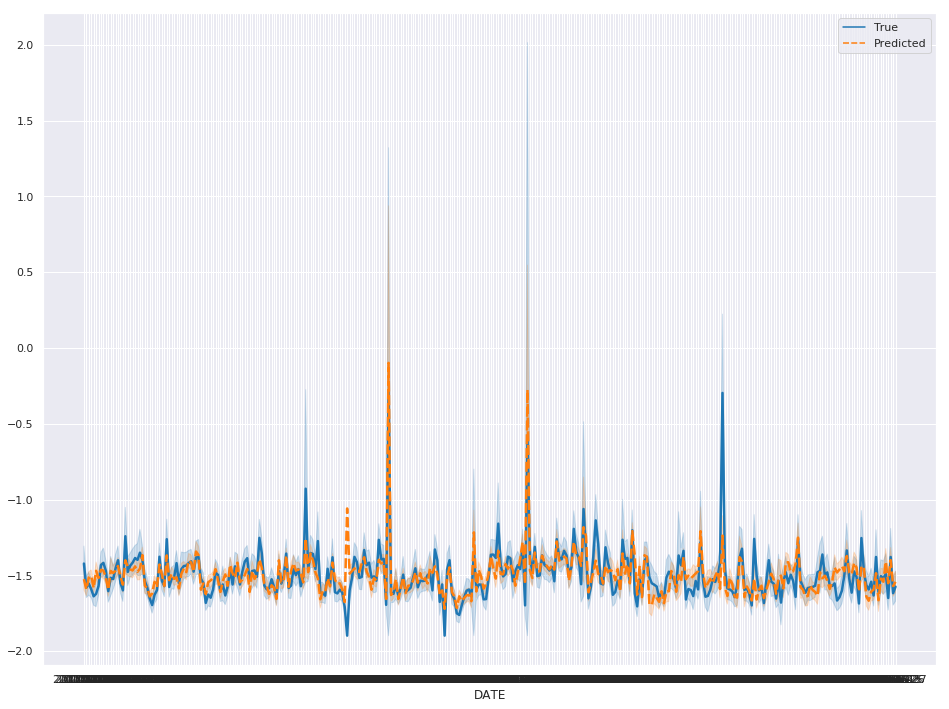

In [24]:
# Check the fit on the training set
dates = model_data['DATE']
X = model_data.copy()
X = sm.add_constant(X, has_constant=True)
X = X[model.model.exog_names]
values = pd.concat([y, pd.Series(model.predict(X), index=y.index)], axis=1).values
data = pd.DataFrame(values, dates, columns=["True", "Predicted"])
sns.set(rc={'figure.figsize':(16, 12)}) # (11.7,8.27) before
sns.lineplot(data=data, palette="tab10", linewidth=2.5)